In [ ]:
import zipfile
import pathlib
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import os
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, InputLayer, Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose, Input, GlobalAveragePooling2D 
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow import keras
import time
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random
from keras import backend as K
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Load dataset

In [ ]:
!wget --no-check-certificate \
    "https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip" \
    -O "/tmp/grapevine.zip"


zip_ref = zipfile.ZipFile('/tmp/grapevine.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-08-05 08:25:56--  https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip
Resolving www.muratkoklu.com (www.muratkoklu.com)... 185.179.25.150
Connecting to www.muratkoklu.com (www.muratkoklu.com)|185.179.25.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113862245 (109M) [application/zip]
Saving to: ‘/tmp/grapevine.zip’

/tmp/grapevine.zip  100%[===================>] 108.59M  8.40MB/s    in 13s     

2022-08-05 08:26:10 (8.29 MB/s) - ‘/tmp/grapevine.zip’ saved [113862245/113862245]



In [ ]:
data_dir = '/tmp/Grapevine_Leaves_Image_Dataset/'
data_dir = pathlib.Path(data_dir)

In [ ]:
leaves_images_dict = {
    'Ak': list(data_dir.glob('Ak/*')),
    'Ala_Idris': list(data_dir.glob('Ala_Idris/*')),
    'Buzgulu': list(data_dir.glob('Buzgulu/*')),
    'Dimnit': list(data_dir.glob('Dimnit/*')),
    'Nazli': list(data_dir.glob('Nazli/*')),
}

leaves_labels_dict = {
    'Ak': 0,
    'Ala_Idris': 1,
    'Buzgulu': 2,
    'Dimnit': 3,
    'Nazli': 4,
}

In [ ]:
X, y = [], []

for leaf_name, images in leaves_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128, 128))
        X.append(resized_img)
        y.append(leaves_labels_dict[leaf_name])

In [ ]:
X = np.array(X)
y = np.array(y)
IMG_SHAPE = X.shape[1:]

In [ ]:
X = X.astype('float32') / 255.0 - 0.5

In [ ]:
classlist=sorted(os.listdir(data_dir))
filepaths = []
labels=[] 

for klass in classlist:
    classpath=os.path.join(data_dir,klass) 
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
            
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)

Train/Test/Validation split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [ ]:
train_df, test_df=train_test_split(df, train_size=.8, shuffle=True, random_state=12, stratify=df['labels']) 
train_df, valid_df=train_test_split(train_df, train_size=.8, shuffle=True, random_state=12, stratify=train_df['labels'])
print('lenght of train: ', len(train_df), '   length of test: ', len(test_df), '   length of validation: ', len(valid_df))

lenght of train:  320    length of test:  100    length of validation:  80


In [ ]:
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
Catseries=pd.Series(classlist, name='Category')
Countseries=pd.Series(countlist, name='Image Count')
crop_df=pd.concat([Catseries, Countseries], axis=1)
print(crop_df.head(class_count))

The number of classes in the dataset is:  5
    Category  Image Count
0         Ak           64
1  Ala_Idris           64
2    Buzgulu           64
3     Dimnit           64
4      Nazli           64


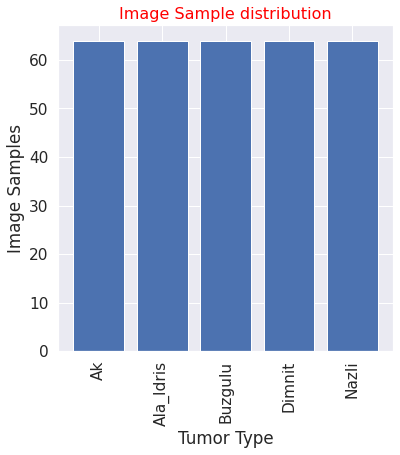

In [ ]:
fig = plt.figure(figsize=(6,6))
labels=crop_df['Category']
sizes=crop_df['Image Count']
x=np.arange(len(labels))
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.title('Image Sample distribution', color='red', fontsize=16)
plt.bar(x,sizes, tick_label=crop_df['Category'])
plt.xlabel('Tumor Type')
plt.ylabel('Image Samples')
plt.show()

Augmentation

In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=200 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,200) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size) 

Initial length of dataframe is  320
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Total Augmented images created=  680
Length of augmented dataframe is now  1000


In [ ]:
working_dir=r'./'
img_size=(200,200)
batch_size=30 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1000 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
test batch size:  50   test steps:  2  number of classes :  5


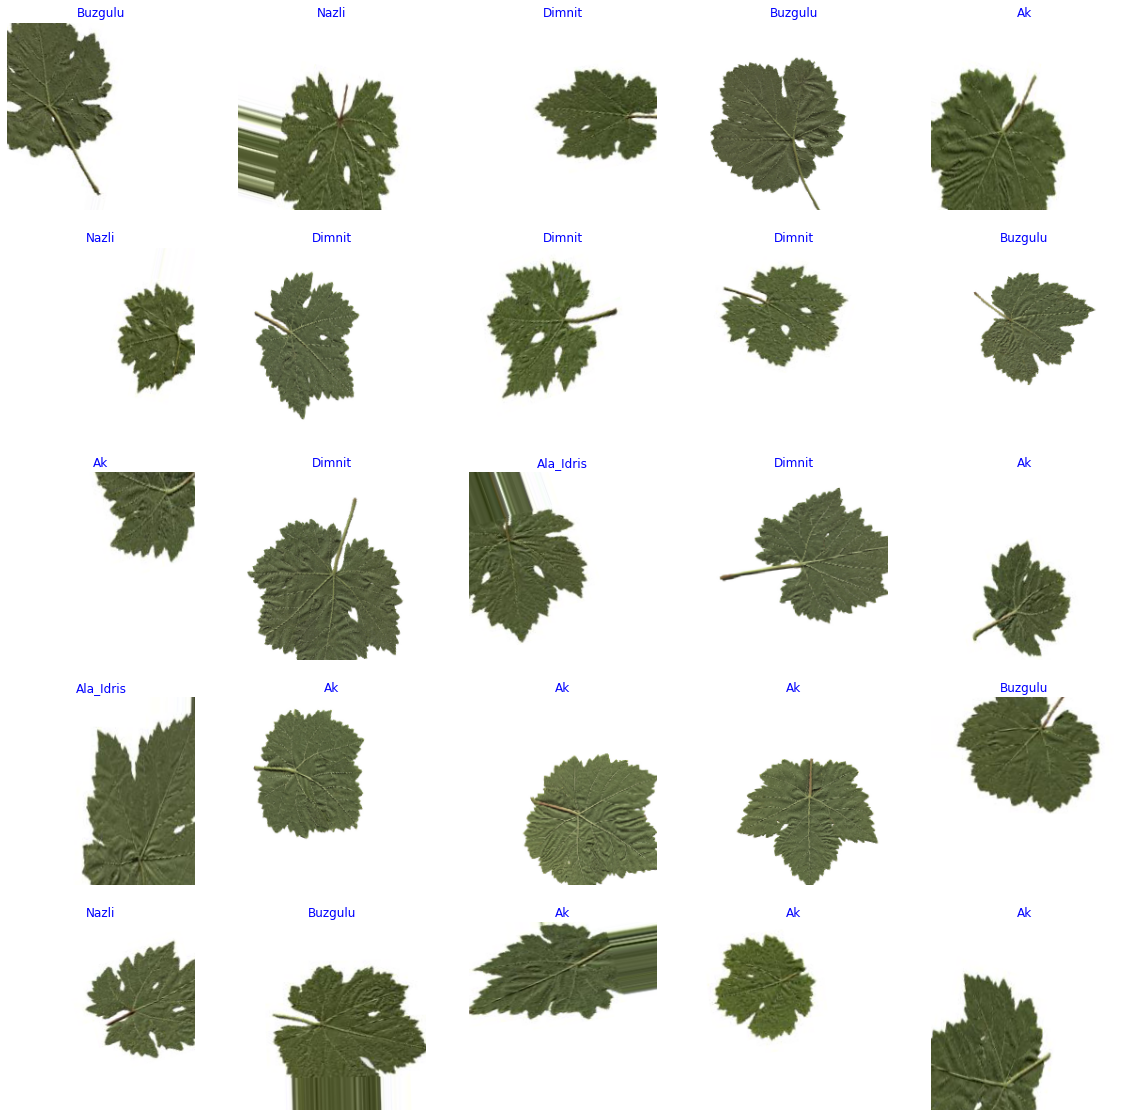

In [ ]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

Classification

In [ ]:
img_size=(200,200)
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [ ]:
epochs=10
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [101]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen, validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 8.8277 - accuracy: 0.5720 
 validation loss of 15.7535 is below lowest loss, saving weights from epoch 1   as best weights
34/34 [==============================] - 533s 15s/step - loss: 8.8277 - accuracy: 0.5720 - val_loss: 15.7535 - val_accuracy: 0.2000
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 7.4607 - accuracy: 0.8180 
 validation loss of  8.7018 is below lowest loss, saving weights from epoch 2   as best weights
34/34 [==============================] - 519s 15s/step - loss: 7.4607 - accuracy: 0.8180 - val_loss: 8.7018 - val_accuracy: 0.5875
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 6.7228 - accuracy: 0.8720 
 validation loss of  8.2792 is below lowest loss, saving weights from epoch 3   as best weights
34/

In [102]:
model.evaluate(test_gen)

2/2 [==============================] - 11s 6s/step - loss: 5.9330 - accuracy: 0.7700


[5.933013439178467, 0.7699999809265137]

In [103]:
model.evaluate(valid_gen)

3/3 [==============================] - 8s 2s/step - loss: 5.8132 - accuracy: 0.8125


[5.813170433044434, 0.8125]

In [105]:
y_pred2 = model.predict(test_gen)
y_pred_classes2 = [np.argmax(element) for element in y_pred2]

print("Classification Report: \n", classification_report(labels, y_pred_classes2))

Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.95      0.76        20
           1       0.78      0.90      0.84        20
           2       0.87      0.65      0.74        20
           3       1.00      0.45      0.62        20
           4       0.78      0.90      0.84        20

    accuracy                           0.77       100
   macro avg       0.81      0.77      0.76       100
weighted avg       0.81      0.77      0.76       100



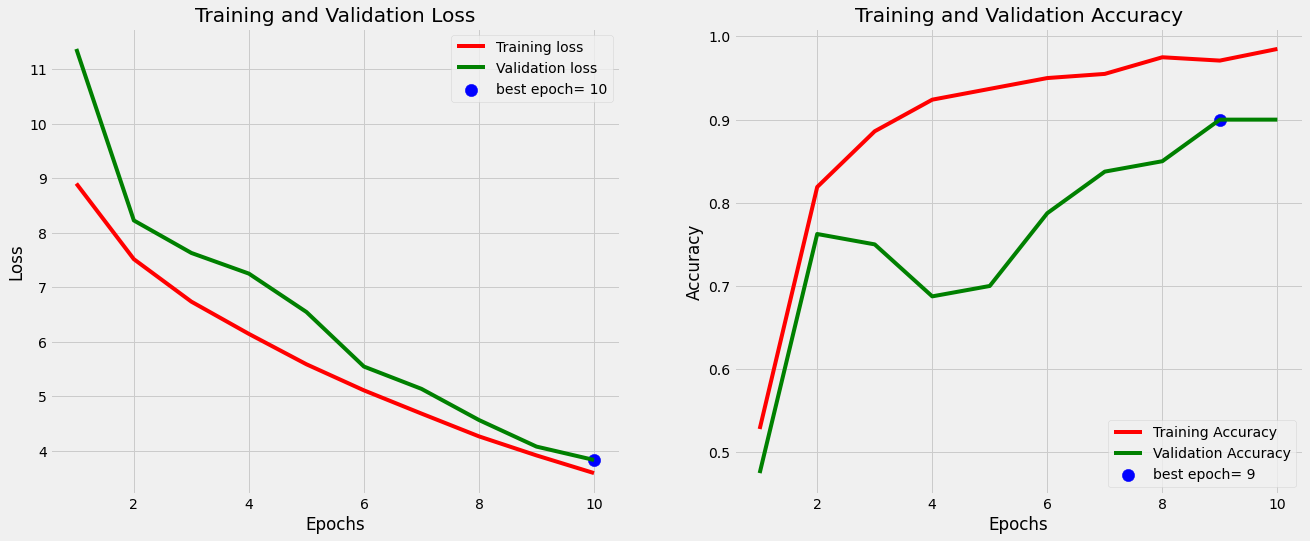

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

Autoencoder denoising and dimentionality reduction

In [ ]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (500, 128, 128, 3)
attr shape: (500,)


38948

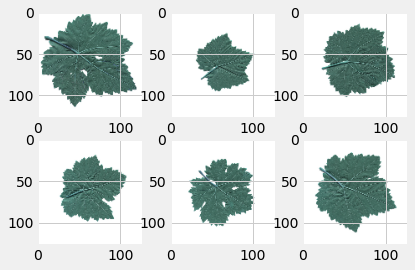

In [ ]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", y.shape)

# try to free memory
del X
import gc
gc.collect()

In [ ]:
def build_deep_autoencoder(img_shape, code_size):

    H,W,C = img_shape
    
    # encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
    encoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
    encoder.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
    encoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(8*8*256))
    decoder.add(Reshape((8, 8, 256)))
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [ ]:
tf.keras.backend.clear_session()
encoder, decoder = build_deep_autoencoder((128,128,3), code_size=128)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [ ]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.
    """
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise

In [ ]:
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() - X_train[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

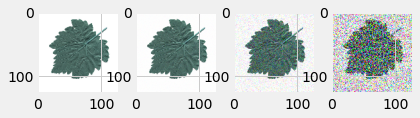

In [ ]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [ ]:
# we use bigger code size here for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

In [ ]:
inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [ ]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [ ]:
for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    #callbacks=[keras_utils.TqdmProgressCallback()],
                    verbose=1)

Epoch 1/25, Generating corrupted samples...
13/13 [==============================] - 29s 2s/step - loss: 0.1062 - val_loss: 0.0528
Epoch 2/25, Generating corrupted samples...
13/13 [==============================] - 28s 2s/step - loss: 0.0381 - val_loss: 0.0323
Epoch 3/25, Generating corrupted samples...
13/13 [==============================] - 27s 2s/step - loss: 0.0283 - val_loss: 0.0285
Epoch 4/25, Generating corrupted samples...
13/13 [==============================] - 27s 2s/step - loss: 0.0257 - val_loss: 0.0267
Epoch 5/25, Generating corrupted samples...
13/13 [==============================] - 27s 2s/step - loss: 0.0241 - val_loss: 0.0246
Epoch 6/25, Generating corrupted samples...
13/13 [==============================] - 29s 2s/step - loss: 0.0225 - val_loss: 0.0232
Epoch 7/25, Generating corrupted samples...
13/13 [==============================] - 27s 2s/step - loss: 0.0214 - val_loss: 0.0221
Epoch 8/25, Generating corrupted samples...
13/13 [==============================] 

In [ ]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

Denoising MSE: 0.014224675484001637


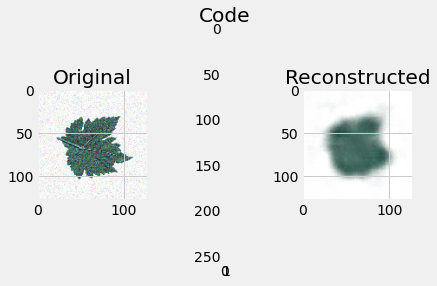

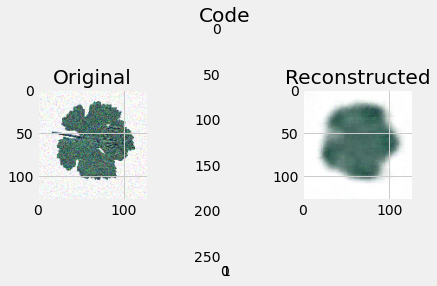

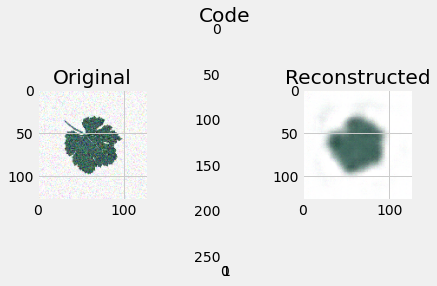

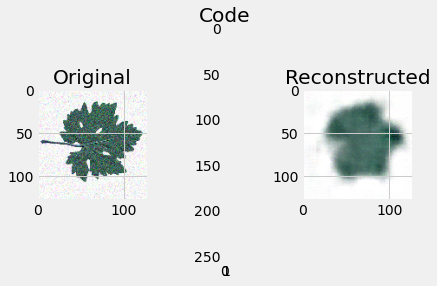

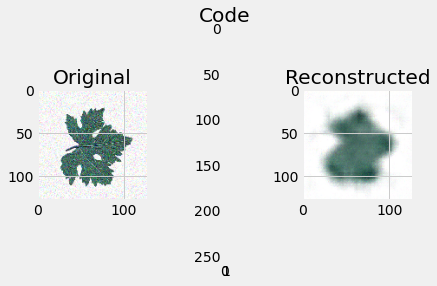

In [ ]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

10 fold cross validation

In [ ]:
h = X_train.shape[1]
w = X_train.shape[2]
c = X_train.shape[3]
dim = h*w*c
X_train4 = X_train.reshape(X_train.shape[0], dim)
X_test4 = X_test.reshape(X_test.shape[0], dim)
X_test4.shape

(100, 49152)

In [ ]:
lr = LogisticRegression(solver='liblinear',multi_class='ovr')
lr.fit(X_train4, y_train)
lr.score(X_test4, y_test)

0.33

In [ ]:
svm = SVC(gamma='auto')
svm.fit(X_train4, y_train)
svm.score(X_test4, y_test)

0.22

In [ ]:
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train4, y_train)
rf.score(X_test4, y_test)

0.42

In [ ]:
def build_model():
    model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='softmax')
])
    
    return model

In [ ]:
kf = KFold(n_splits=10)

In [ ]:
def get_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.evaluate(X_test,y_test)

In [ ]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [ ]:
folds = StratifiedKFold(n_splits=10)

scores_model = []
scores_logistic = []
scores_svm = []
scores_rf = []
model = build_model()
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
for train_index, test_index in folds.split(X_train,y_train):
  X_train2, X_test2, y_train2, y_test2 = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
  scores_model.append(get_eval(model, X_train, X_test, y_train, y_test))
  scores_logistic.append(get_score(LogisticRegression(solver='liblinear',multi_class='ovr'), X_train4, X_test4, y_train, y_test))  
  scores_svm.append(get_score(SVC(gamma='auto'), X_train4, X_test4, y_train, y_test))
  scores_rf.append(get_score(RandomForestClassifier(n_estimators=40), X_train4, X_test4, y_train, y_test))




4/4 [==============================] - 1s 126ms/step - loss: 0.0000e+00 - accuracy: 0.1900


In [ ]:
scores_model

[[0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142],
 [0.0, 0.1899999976158142]]

In [ ]:
scores_logistic

[0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33]

In [ ]:
scores_svm

[0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22]

In [ ]:
scores_rf

[0.32, 0.4, 0.43, 0.46, 0.37, 0.42, 0.39, 0.39, 0.33, 0.4]

Check different seed

In [ ]:
main_path = '/tmp/Grapevine_Leaves_Image_Dataset/'
path_Ak = main_path + 'Ak'
path_Ala_Idris = main_path + 'Ala_Idris'
path_Buzgulu = main_path + 'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'

In [ ]:
main_df = pd.DataFrame()

In [ ]:
main_df['images'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)

In [ ]:
classes = []
paths = []
for image in main_df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

In [ ]:
main_df['classes'] = classes
main_df['path'] = paths

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
rnseed=np.random.randint(1000, size=(10))

In [ ]:
def initialize_nn_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.set_random_seed(seed)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess) 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(main_df[['path', 'classes']], main_df[['classes']], test_size=0.2, random_state=rnseed[0])

Compare different classifications

In [ ]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 400 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [ ]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 400 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [ ]:
vgg19 = VGG19(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in vgg19.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg19.output)
predictions = Dense(5, activation='softmax')(x)

model_vgg = Model(inputs = vgg19.input, outputs = predictions)

In [ ]:
resnet50 = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(5, activation='softmax')(x)

model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

In [ ]:
model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history_vgg = model_vgg.fit(
      train_generator_vgg,
      validation_data=val_generator_vgg,
      epochs=5)

Epoch 1/5
13/13 [==============================] - 318s 25s/step - loss: 2.2940 - accuracy: 0.1925 - val_loss: 2.0822 - val_accuracy: 0.1900
Epoch 2/5
13/13 [==============================] - 317s 25s/step - loss: 1.8077 - accuracy: 0.2925 - val_loss: 1.8352 - val_accuracy: 0.2900
Epoch 3/5
13/13 [==============================] - 316s 25s/step - loss: 1.5797 - accuracy: 0.3375 - val_loss: 1.5889 - val_accuracy: 0.3900
Epoch 4/5
13/13 [==============================] - 317s 25s/step - loss: 1.3551 - accuracy: 0.4725 - val_loss: 1.6261 - val_accuracy: 0.3400
Epoch 5/5
13/13 [==============================] - 318s 25s/step - loss: 1.3045 - accuracy: 0.4475 - val_loss: 1.4464 - val_accuracy: 0.4200


In [ ]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=5)

Epoch 1/5
13/13 [==============================] - 99s 8s/step - loss: 1.1960 - accuracy: 0.5775 - val_loss: 1.0741 - val_accuracy: 0.6400
Epoch 2/5
13/13 [==============================] - 97s 7s/step - loss: 1.0819 - accuracy: 0.6425 - val_loss: 1.0572 - val_accuracy: 0.6500
Epoch 3/5
13/13 [==============================] - 97s 8s/step - loss: 0.9798 - accuracy: 0.7050 - val_loss: 0.9829 - val_accuracy: 0.7000
Epoch 4/5
13/13 [==============================] - 97s 8s/step - loss: 0.9515 - accuracy: 0.7050 - val_loss: 0.8622 - val_accuracy: 0.7400
Epoch 5/5
13/13 [==============================] - 98s 8s/step - loss: 0.8590 - accuracy: 0.7300 - val_loss: 0.8624 - val_accuracy: 0.7300


Plots and confusion matrix

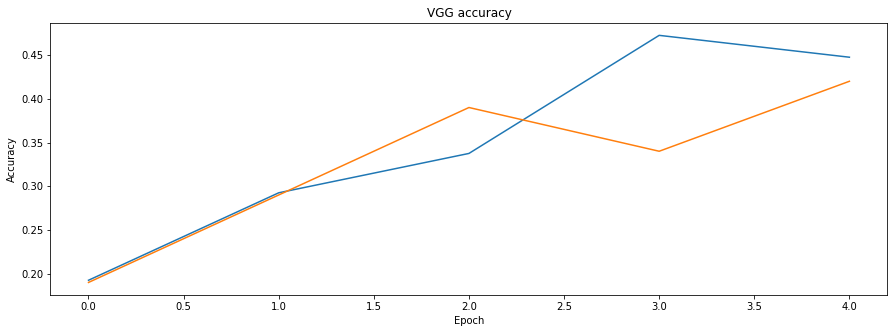

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('VGG accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

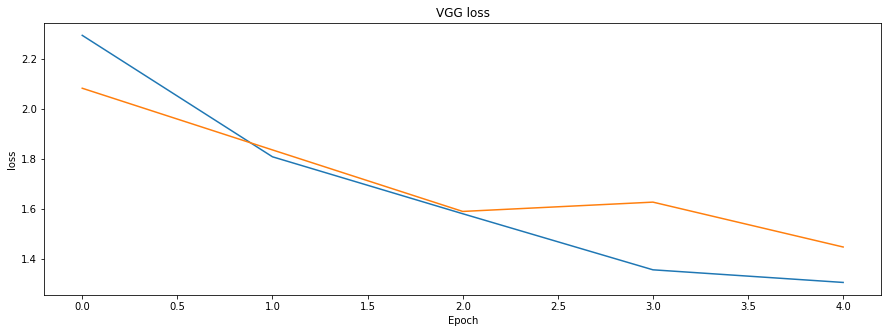

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('VGG loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

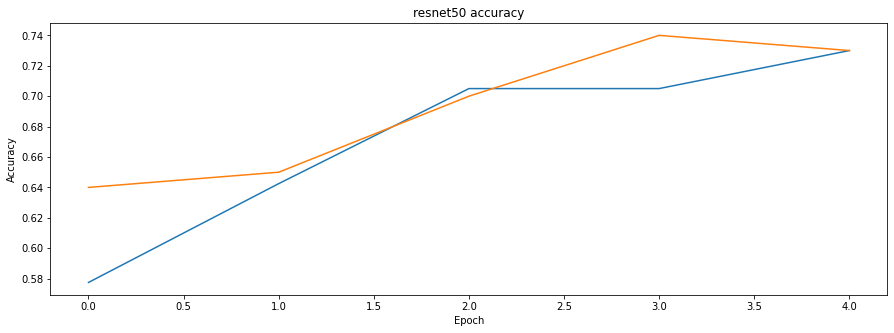

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('resnet50 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

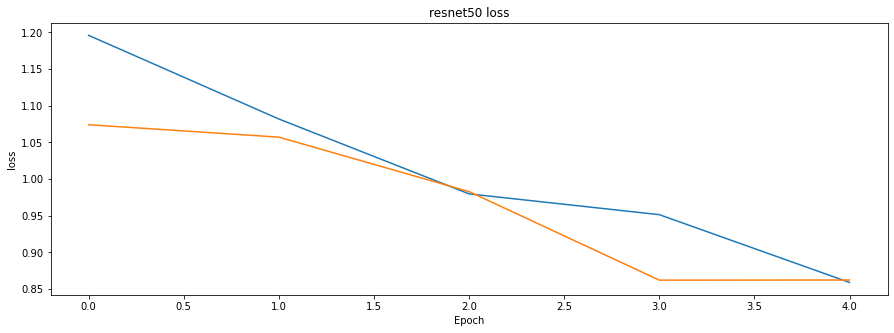

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('resnet50 loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
y_pred = model_vgg.predict(val_generator_vgg)

In [ ]:
y_pred_classes = [np.argmax(element) for element in y_pred]

val = [i for i in y_val['classes']]
for i, e in enumerate(val):
  e = leaves_labels_dict[e]
  val[i] = e


In [ ]:
 array = confusion_matrix(val, y_pred_classes)

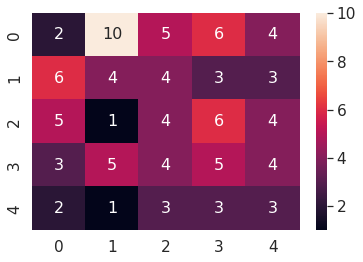

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [106]:
 array2 = confusion_matrix(y_test, y_pred_classes2)

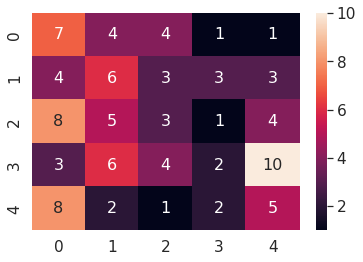

In [107]:
df_cm = pd.DataFrame(array2, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()